##Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

##DATA CLEANING

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ecom/Amazon Sale Report.csv')
print("Initial data shape:", df.shape)

Initial data shape: (128975, 24)


/tmp/ipython-input-10-1141639257.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/ecom/Amazon Sale Report.csv')


In [ ]:
df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [ ]:
# 1. Drop unwanted columns
df.drop(columns=['B2B', 'Unnamed: 22', 'ship-country', 'currency', 'fulfilled-by'], inplace=True)
print("\nAfter dropping columns:", df.shape)


After dropping columns: (128975, 19)


In [ ]:
# 2. Handle Courier Status based on Status and Qty
condition = df['Courier Status'].isna() & (df['Qty'] == 0)
df.loc[condition & (df['Status'] == 'Cancelled'), 'Courier Status'] = 'Cancelled'
df.loc[condition & (df['Status'].isin(['Shipped - Delivered to Buyer', 'Shipped - Returned to Seller'])), 'Courier Status'] = 'Shipped'

In [ ]:
# 3. Clean Amount column
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

# Fill missing Amount values with mode by Category, Size, Qty
missing_mask = df['Amount'].isna()
mode_values = (
    df.groupby(['Category', 'Size', 'Qty'])['Amount']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
    .rename(columns={'Amount': 'Mode_Amount'})
)

df = df.merge(mode_values, on=['Category', 'Size', 'Qty'], how='left')
df.loc[missing_mask, 'Amount'] = df.loc[missing_mask, 'Mode_Amount']
df.drop(columns='Mode_Amount', inplace=True)

# Remove rows with missing Amount
df = df[~df['Amount'].isna()]
print("\nAfter handling Amount:", df.shape)


After handling Amount: (128966, 19)


In [ ]:
# 4. Remove rows with missing ship-state
df = df[~df['ship-state'].isna()]
print("\nAfter handling ship-state:", df.shape)


After handling ship-state: (128933, 19)


In [ ]:
# 5. Standardize ship-state
# Remove APO and AR rows
df = df[~df['ship-state'].str.upper().isin(['APO', 'AR'])]

# Convert to uppercase and clean
df['ship-state'] = df['ship-state'].str.upper().str.strip()
df['ship-city'] = df['ship-city'].str.upper().str.strip()

# Standardize state names
state_replacements = {
    'DELHI': 'NEW DELHI',
    'NEW DELHI': 'NEW DELHI',
    'NL': 'NAGALAND',
    'NAGALAND': 'NAGALAND',
    'ODISHA': 'ODISHA',
    'ORISSA': 'ODISHA',
    'PB': 'PUNJAB',
    'PUNJAB': 'PUNJAB',
    'PUNJAB/MOHALI/ZIRAKPUR': 'PUNJAB',
    'PUDUCHERRY': 'PUDUCHERRY',
    'PONDICHERRY': 'PUDUCHERRY',
    'RAJASTHAN': 'RAJASTHAN',
    'RAJSTHAN': 'RAJASTHAN',
    'RAJSHSTHAN': 'RAJASTHAN',
    'RJ': 'RAJASTHAN',
}
df['ship-state'] = df['ship-state'].replace(state_replacements)


/tmp/ipython-input-16-3110948891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ship-state'] = df['ship-state'].str.upper().str.strip()
/tmp/ipython-input-16-3110948891.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ship-city'] = df['ship-city'].str.upper().str.strip()


In [ ]:
# 6. Handle Coupon Applied column
df['Coupon Applied'] = df['promotion-ids'].apply(lambda x: 'NO' if pd.isna(x) else 'YES')
df.drop(columns='promotion-ids', inplace=True)

In [ ]:
# 7. Handle zero Amount values
# Create lookup tables
mode_csz = (
    df[df['Amount'] > 0]
    .groupby(['Category', 'Size', 'Qty'])['Amount']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .to_dict()
)

mode_cs = (
    df[df['Amount'] > 0]
    .groupby(['Category', 'Size'])['Amount']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .to_dict()
)

mode_c = (
    df[df['Amount'] > 0]
    .groupby(['Category'])['Amount']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .to_dict()
)

global_median = df[df['Amount'] > 0]['Amount'].median()

def fill_zero_amount(row):
    if row['Amount'] != 0:
        return row['Amount']

    key_csz = (row['Category'], row['Size'], row['Qty'])
    key_cs = (row['Category'], row['Size'])
    key_c = row['Category']

    return (
        mode_csz.get(key_csz)
        or mode_cs.get(key_cs)
        or mode_c.get(key_c)
        or global_median
    )

df['Amount'] = df.apply(fill_zero_amount, axis=1)

In [ ]:

# Final checks and save
print("\nFinal missing values:")
print(df.isnull().sum())
print("\nFinal data shape:", df.shape)


Final missing values:
index                 0
Order ID              0
Date                  0
Status                0
Fulfilment            0
Sales Channel         0
ship-service-level    0
Style                 0
SKU                   0
Category              0
Size                  0
ASIN                  0
Courier Status        0
Qty                   0
Amount                0
ship-city             0
ship-state            0
ship-postal-code      0
Coupon Applied        0
dtype: int64

Final data shape: (128931, 19)


In [ ]:
# Remove trailing spaces and convert 'Date' to proper datetime format
df['Date'] = pd.to_datetime(df['Date'].str.strip(), format='%m-%d-%y')

In [ ]:

# Save cleaned data
df.to_csv("Amazon_Sale_Report_Final.csv", index=False)
df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-city,ship-state,ship-postal-code,Coupon Applied
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,Cancelled,0,647.62,MUMBAI,MAHARASHTRA,400081.0,NO
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,406.00,BENGALURU,KARNATAKA,560085.0,YES
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,YES
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,Cancelled,0,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,NO
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,574.00,CHENNAI,TAMIL NADU,600073.0,NO


##Exploratry Data Analysis

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ecom/Amazon_Sale_Report_Final.csv')
print("Initial data shape:", df.shape)

Initial data shape: (128931, 19)


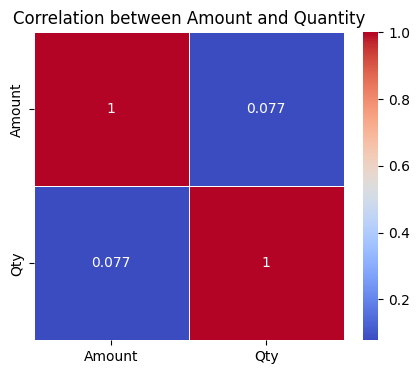

In [ ]:
# 1. Correlation Analysis
# Calculate correlation matrix
corr = df[['Amount', 'Qty']].corr()

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between Amount and Quantity')
plt.show()


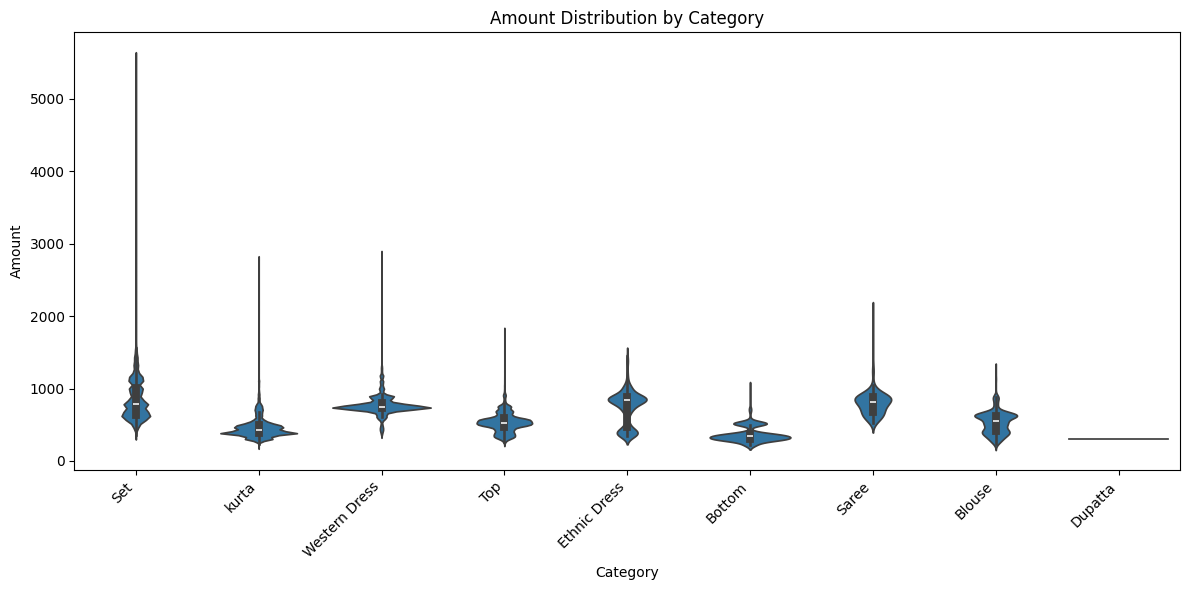

In [ ]:
# 2. Amount Distribution by Category
plt.figure(figsize=(12, 6))  # Increase figure size for better spacing
sns.violinplot(data=df, x='Category', y='Amount')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.title('Amount Distribution by Category')
plt.tight_layout()
plt.show()


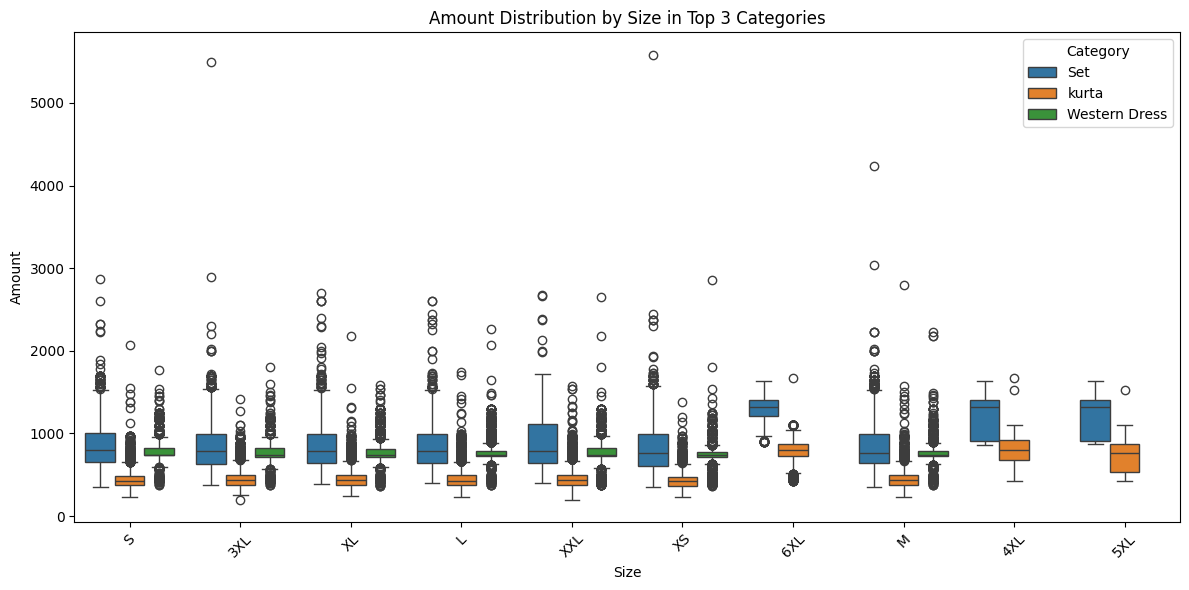

In [ ]:
# 3. Size vs. Amount in Top Categories
# Get the top 3 most frequent categories
top_3 = df['Category'].value_counts().head(3).index.tolist()

# Now plot Size vs Amount only for top 3 categories
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['Category'].isin(top_3)], x='Size', y='Amount', hue='Category')
plt.title("Amount Distribution by Size in Top 3 Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


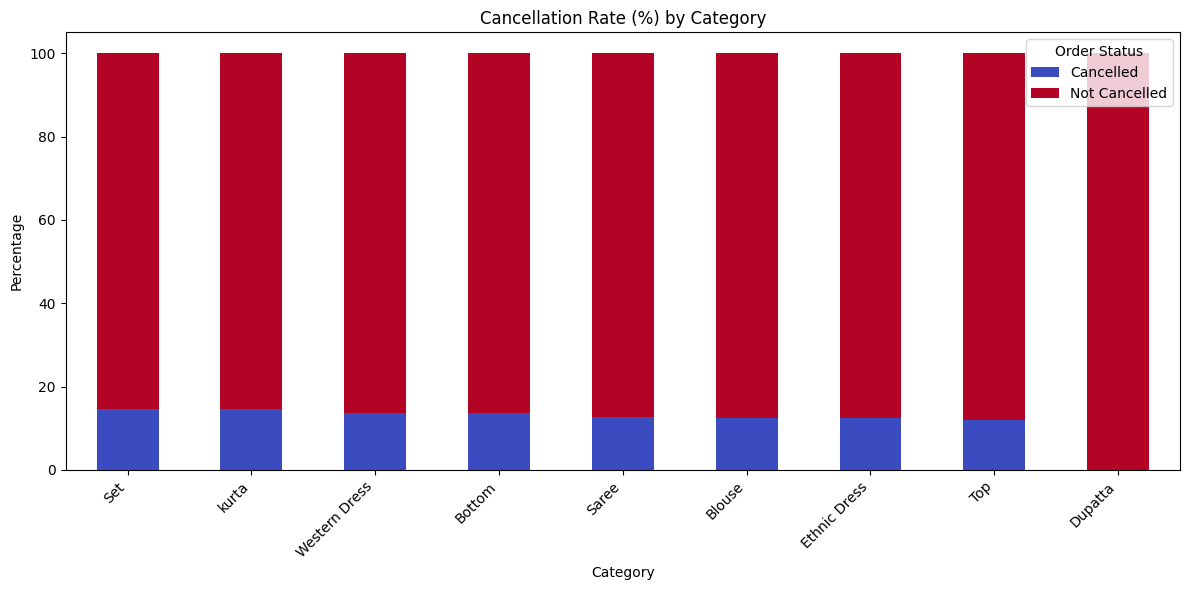

In [ ]:
# 4. Cancellation Rate by Category
#Create a new column: 'Cancelled' or 'Not Cancelled'
df['Cancel_Flag'] = df['Status'].apply(lambda x: 'Cancelled' if 'cancelled' in x.lower() else 'Not Cancelled')

# Create normalized stacked bar chart
category_status = pd.crosstab(df['Category'], df['Cancel_Flag'], normalize='index') * 100
category_status.sort_values('Cancelled', ascending=False).plot(
    kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm'
)

plt.ylabel("Percentage")
plt.title("Cancellation Rate (%) by Category")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Order Status")
plt.tight_layout()
plt.show()


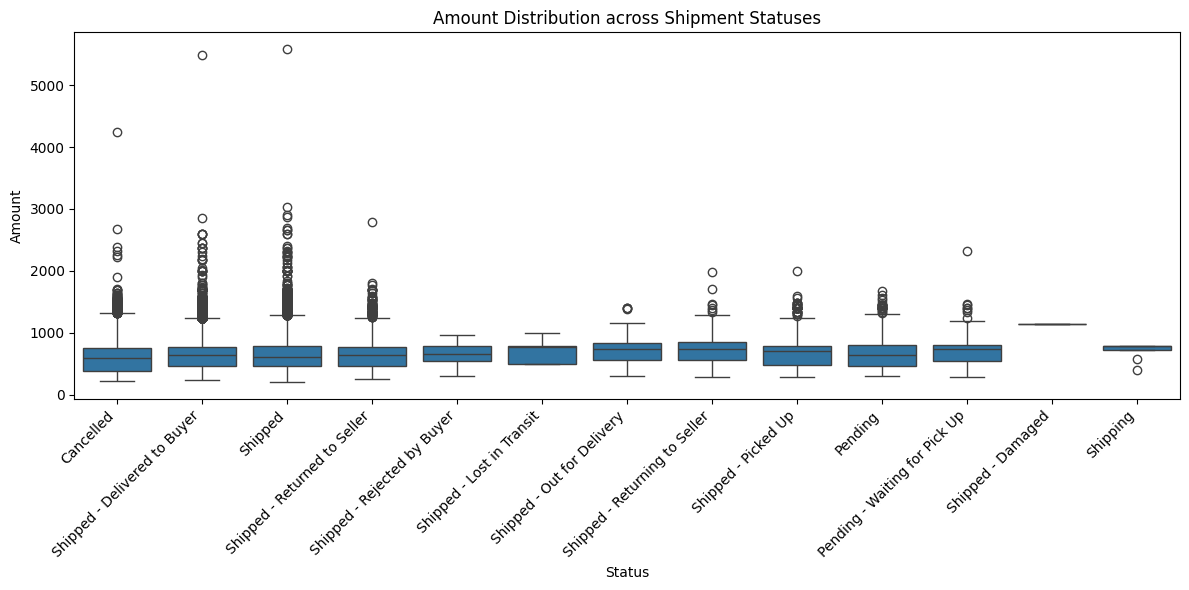

In [ ]:
# 5. Shipment Status vs. Amount
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Status', y='Amount')
plt.xticks(rotation=45, ha='right')
plt.title("Amount Distribution across Shipment Statuses")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

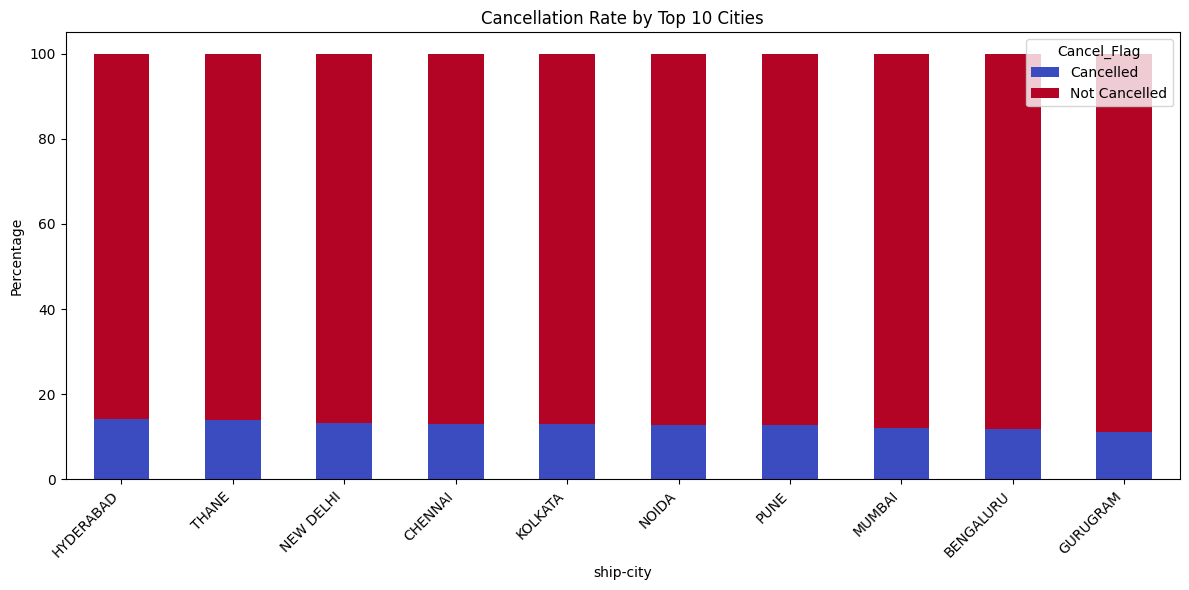

In [ ]:
# Create Cancel Flag
df['Cancel_Flag'] = df['Status'].apply(lambda x: 'Cancelled' if 'cancelled' in x.lower() else 'Not Cancelled')

# Cancellation Rate by City (Top 10 cities)
top_cities = df['ship-city'].value_counts().head(10).index
city_cancel = df[df['ship-city'].isin(top_cities)]

plt.figure(figsize=(12, 6))
city_cancel_group = pd.crosstab(city_cancel['ship-city'], city_cancel['Cancel_Flag'], normalize='index') * 100
city_cancel_group.sort_values(by='Cancelled', ascending=False).plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12,6))
plt.title("Cancellation Rate by Top 10 Cities")
plt.ylabel("Percentage")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


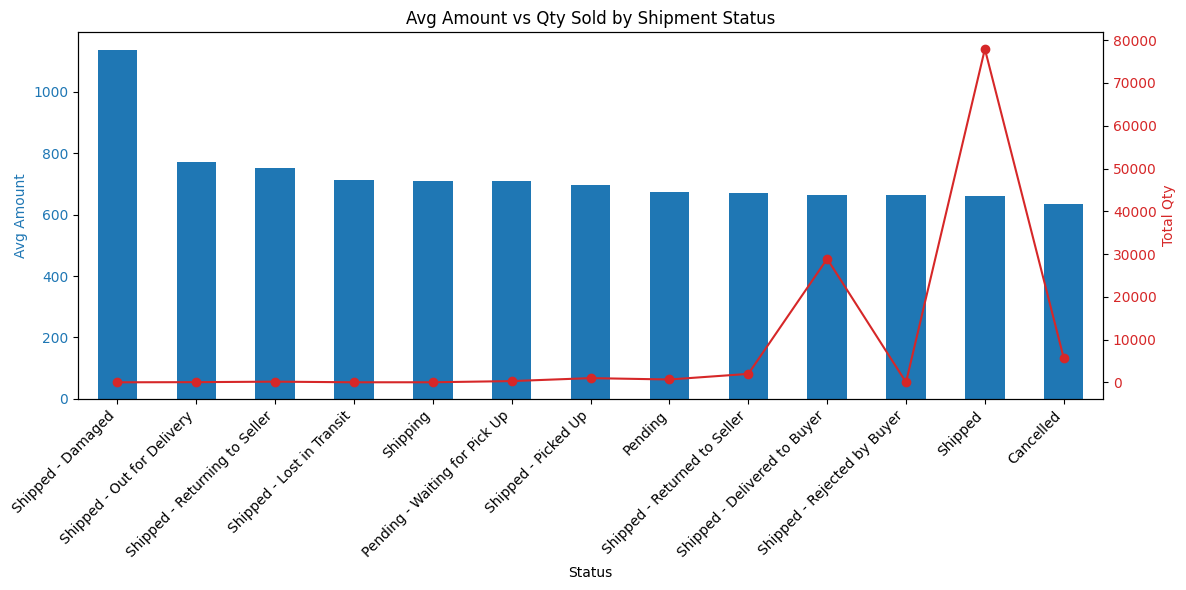

In [ ]:
# Aggregated view of amount and quantity by shipment status
status_summary = df.groupby('Status').agg({'Amount': 'mean', 'Qty': 'sum'}).sort_values(by='Amount', ascending=False)

# Plot combined metrics
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot mean amount (bar)
color = 'tab:blue'
ax1.set_xlabel('Shipment Status')
ax1.set_ylabel('Avg Amount', color=color)
status_summary['Amount'].plot(kind='bar', color=color, ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45, ha='right')

# Add second axis for quantity sold
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Qty', color=color)
status_summary['Qty'].plot(kind='line', marker='o', color=color, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Avg Amount vs Qty Sold by Shipment Status")
fig.tight_layout()
plt.show()


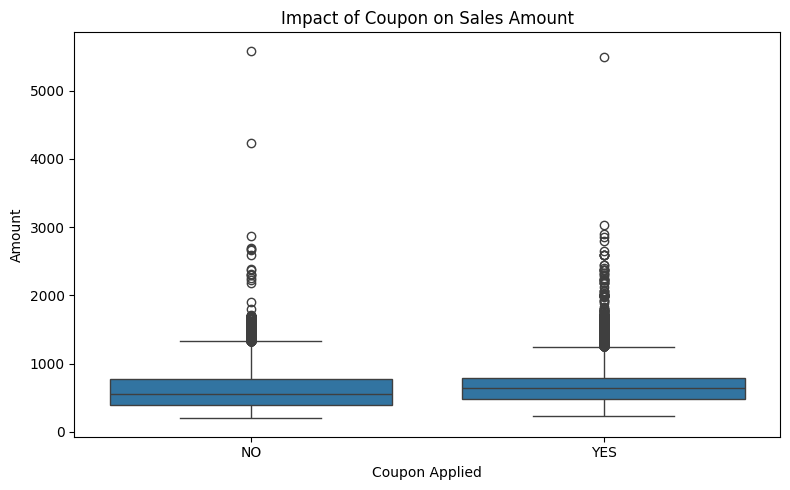

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Coupon Applied', y='Amount')
plt.title("Impact of Coupon on Sales Amount")
plt.tight_layout()
plt.show()


In [ ]:
high_value = df[df['Amount'] > df['Amount'].quantile(0.99)]
print("Top 1% high value transactions:\n", high_value[['Category', 'Size', 'Amount']].head())


Top 1% high value transactions:
     Category Size   Amount
265      Set  XXL  2130.00
299      Set    S  1463.00
324      Set    L  1902.86
349      Set  3XL  1999.00
398      Set    S  1463.00


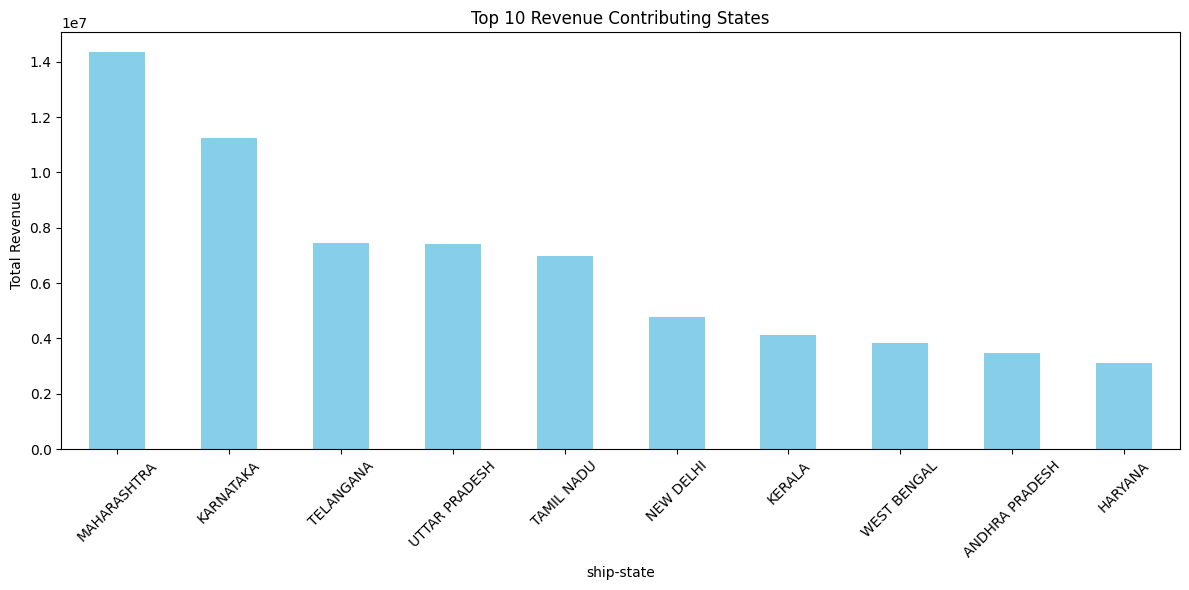

In [ ]:
state_rev = df.groupby('ship-state')['Amount'].sum().sort_values(ascending=False)
plt.figure(figsize=(12,6))
state_rev.head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Revenue Contributing States")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##DataSet Split

In [ ]:
df.columns.tolist()

['index',
 'Order ID',
 'Date',
 'Status',
 'Fulfilment',
 'Sales Channel ',
 'ship-service-level',
 'Style',
 'SKU',
 'Category',
 'Size',
 'ASIN',
 'Courier Status',
 'Qty',
 'Amount',
 'ship-city',
 'ship-state',
 'ship-postal-code',
 'Coupon Applied',
 'Cancel_Flag']

In [ ]:
import pandas as pd

# Load the full dataset
df = pd.read_csv("/content/drive/MyDrive/ecom/Amazon_Sale_Report_Final.csv")

# Clean column names
df.columns = df.columns.str.strip()

# --- Orders Table ---
orders_cols = [
    'index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel',
    'ship-service-level', 'Courier Status', 'Qty', 'Amount',
    'Coupon Applied', 'SKU'
]
orders = df[orders_cols]

# --- Products Table ---
products_cols = ['Style', 'SKU', 'Category', 'Size', 'ASIN']
products = df[products_cols].drop_duplicates()

# --- Shipping Table ---
shipping_cols = ['Order ID', 'ship-city', 'ship-state', 'ship-postal-code']
shipping = df[shipping_cols].drop_duplicates()

# Save as CSV
orders.to_csv("orders_table.csv", index=False)
products.to_csv("products_table.csv", index=False)
shipping.to_csv("shipping_table.csv", index=False)

print("✅ All three tables created and saved.")



✅ All three tables created and saved.


In [ ]:
# Load your orders table
df = pd.read_csv("/content/orders_table.csv")

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')

# Format the date as YYYY-MM-DD (SQL-friendly format)
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# Save to new CSV
df.to_csv("/content/orders_table_fixed.csv", index=False)